In [0]:
import numpy as np
import nltk
from zipfile import ZipFile
from nltk.tokenize import TreebankWordTokenizer
import pickle
import random
from itertools import combinations
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from pathlib import Path

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Load the data

In [0]:
#!wget https://github.com/thedenaas/hse_seminars/tree/master/2018/seminar_13/data.zip

In [0]:
with ZipFile("data2.zip", 'r') as zip_ref:
    zip_ref.extractall('data')

In [0]:
raw_documents = []
snippets = []
with open( "data/data.txt", "r") as f:
    for line in f.readlines():
        text = line.strip()
        raw_documents.append( text.lower() )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))


# custom stopwords
custom_stop_words = []
with open( "data/stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Read 4551 raw text documents
Stopword list has 350 entries


# Some preprocessing

In [0]:
tokenizer = TreebankWordTokenizer()
dataset = [tokenizer.tokenize(x) for x in raw_documents]

if not Path('vocab.pickle').exists():
    vocab_freq = {}
    for doc in dataset:
        for word in doc:
            if word in vocab_freq:
                vocab_freq[word] += 1
            else:
                vocab_freq[word] = 1
else:
    with open('vocab.pickle', 'rb') as f:
        vocab_freq = pickle.load(f)

In [0]:
vocab_list = [k for k, v in vocab_freq.items() if v > 50]

In [0]:
tokenizer = TreebankWordTokenizer()
dataset = [tokenizer.tokenize(x) for x in raw_documents]
for i, doc in enumerate(dataset):
    dataset[i] = list(filter(lambda x: x in vocab_list and x not in custom_stop_words, doc))

# Load pretrained embeddings

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-03-20 12:26:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-20 12:26:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-20 12:26:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec

if not Path('emb_word2vec_format.txt').exists():
    glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="emb_word2vec_format.txt")

model = gensim.models.KeyedVectors.load_word2vec_format('emb_word2vec_format.txt')
weights = torch.FloatTensor(model.vectors)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
word2idx = {k:i for i, k in enumerate(model.vocab.keys())}
weight = np.array([model[k] for _, k in enumerate(model.vocab.keys())])

# Create dataset

In [0]:
encode = lambda x: word2idx[x] if x in model.vocab.keys() else word2idx['unk']
dataset = [[encode(x) for x in y] for y in dataset]

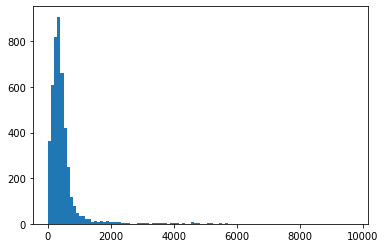

In [0]:
from matplotlib import pyplot as plt

plt.hist([len(x) for x in dataset], bins=100)
plt.show()

In [0]:
print(len(dataset))
print(len(list(filter(lambda x: len(x) < 1024, dataset))))

4551
4278


In [0]:
max_len = 512
tensor_dataset = []
for doc in dataset:
    tensor_dataset.append(torch.LongTensor(doc[:max_len]+(max_len - len(doc))*[encode('pad')]))

In [0]:
padding_idx = word2idx['pad']

# Batch sampler

In [0]:
class DataSampler():
    def __init__(self, dataset, negative_size=10, batch_size=5):
        self.dataset = random.sample(dataset, len(dataset))
        self.negative_size = negative_size
        self.batch_size = batch_size
        self.cur_idx = 0 

    def __next__(self):
        batch = {'positive': [], 'negative': []}
        for j in range(self.batch_size):
            positive = self.dataset[self.cur_idx]
            rest = self.dataset[:self.batch_size*self.cur_idx+j] + self.dataset[self.batch_size*self.cur_idx+j+1:]
            negative = torch.stack(random.sample(rest, self.negative_size), 0)
            batch['positive'].append(positive)
            batch['negative'].append(negative)
        batch['positive'] = torch.stack(batch['positive'], 0)
        batch['negative'] = torch.stack(batch['negative'], 0)
          
        return batch

    def __iter__(self):
        self.cur_idx = 0
        for _ in range(len(self.dataset) // self.batch_size):
            self.cur_idx += 1
            yield self.__next__()

    def __len__(self):
        return len(self.dataset) // self.batch_size

# Model

In [0]:
class TopicModel(nn.Module):
    def __init__(self, vocab_size, d, n_topics):
        super().__init__()
        self.vocab_size = vocab_size
        self.d = d
        self.embedding = nn.Embedding(self.vocab_size, d)
        self.M_matrix = nn.Linear(d, d, bias=False)
        self.proj = nn.Linear(d, n_topics)

        self.T_matrix = nn.Parameter(nn.init.xavier_uniform_(torch.empty(n_topics, d)))

    def load_embedding_weight(self, weight, padding_idx=None, freeze=False):
        self.embedding = nn.Embedding(self.vocab_size, self.d).from_pretrained(weight, padding_idx=padding_idx)
        if freeze == True:
            self.embedding.requires_grad = False

    def forward(self, batch):
        pos_emb = self.embedding(batch['positive'])
        neg_context_emb = self.embedding(batch['negative']).mean(2)

        sent_context = pos_emb.mean(1)
        transf_emb = self.M_matrix(pos_emb)
        sim = torch.einsum('ble,be->bl', transf_emb, sent_context)
        alphas = F.softmax(sim, -1)
        attn = torch.einsum('ble,bl->be', pos_emb, alphas)
        p = F.softmax(self.proj(attn), -1)
        r = p @ self.T_matrix
        
        pos = torch.einsum('be,be->b', r, attn)
        neg = torch.einsum('be,bme->bm', r, neg_context_emb)

        return pos, neg 
    
    def get_probs(self, inp):
        pos_emb = self.embedding(inp)

        sent_context = pos_emb.mean(0)
        transf_emb = self.M_matrix(pos_emb)
        sim = torch.einsum('le,e->l', transf_emb, sent_context)
        alphas = F.softmax(sim, -1)
        attn = torch.einsum('le,l->e', pos_emb, alphas)
        p = F.softmax(self.proj(attn))

        return p

# Training

In [0]:
n_epoch = 15
batch_size = 10
negative_size = 20
lamda = 1

In [0]:
n_topics_range = [3, 4, 5]
topic_models = []

In [0]:
for n_topics in n_topics_range:
    print(f'{n_topics} topics \n')

    topic_model = TopicModel(len(word2idx), 300, n_topics=n_topics)
    topic_model.load_embedding_weight(torch.FloatTensor(weight), padding_idx=padding_idx, freeze=True)
    topic_model.to(device)
    optimizer = Adam(topic_model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

    def topic_loss_function(pos, neg, model):
        pos = pos.unsqueeze(-1)
        delta = 1 - pos + neg
        delta = F.relu(delta)
        reg = torch.frobenius_norm(model.T_matrix @ model.T_matrix.permute(1,0)  - torch.eye(n_topics).to(pos.device))
        loss = delta.sum() / batch_size + lamda * reg / len(sampler) / batch_size
        return loss

    topic_model.train()
    for ep in range(n_epoch):
        ep_loss = 0
        sampler = DataSampler(tensor_dataset, negative_size=negative_size, batch_size=batch_size)
        for step, batch in enumerate(iter(sampler)):
            for k, v in batch.items():
                batch[k] = v.to(device)
            optimizer.zero_grad()
            pos, neg = topic_model(batch)
            loss = topic_loss_function(pos, neg, topic_model)
            loss.backward()
            optimizer.step()
            ep_loss += loss.item()
        scheduler.step(ep_loss)
        print(f'Epoch {ep}, loss {ep_loss / len(sampler)}')

    topic_model.eval()
    with torch.no_grad():
        W = []
        for x in tensor_dataset:
            W.append(topic_model.get_probs(x.to(device)).cpu().numpy())
        W = np.array(W)

        H = []
        for x in vocab_list:
            if x not in word2idx.keys():
                continue
            H.append(topic_model.get_probs(torch.tensor([word2idx[x]]).to(device)).cpu().numpy())
        H = np.array(H)
        H = H.transpose()

    topic_models.append((n_topics, W, H))

3 topics 

Epoch 0, loss 1.2757668178815749
Epoch 1, loss 0.05699140659039635
Epoch 2, loss 0.02544731321427357
Epoch 3, loss 0.015426392713433726
Epoch 4, loss 0.010602147052970275
Epoch 5, loss 0.008985042452791726
Epoch 6, loss 0.005846085080590386
Epoch 7, loss 0.005054483994595952
Epoch 8, loss 0.004317113649929045
Epoch 9, loss 0.00414777402996321
Epoch 10, loss 0.0034615964168211917
Epoch 11, loss 0.048470345384359445
Epoch 12, loss 0.00667789093484836
Epoch 13, loss 0.0060544094526219176
Epoch 14, loss 0.003633786946187144


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


4 topics 

Epoch 0, loss 0.5957975877777694
Epoch 1, loss 0.003851768232825734
Epoch 2, loss 0.006993703343931094
Epoch 3, loss 0.005690827013305542
Epoch 4, loss 0.002368627160347507
Epoch 5, loss 0.0017878309361749217
Epoch 6, loss 0.023471742407751402
Epoch 7, loss 0.014365355924646892
Epoch 8, loss 0.0025896609508800883
Epoch 9, loss 0.00097761982348287
Epoch 10, loss 0.0009158142896082539
Epoch 11, loss 0.0013887139848320856
Epoch 12, loss 0.001705390617512371
Epoch 13, loss 0.0009087988060315723
Epoch 14, loss 0.000926125219480677
5 topics 

Epoch 0, loss 0.8170271799732051
Epoch 1, loss 0.02137350332373139
Epoch 2, loss 0.008599114472783364
Epoch 3, loss 0.002677136528878831
Epoch 4, loss 0.004802201888370481
Epoch 5, loss 0.0012883031881506463
Epoch 6, loss 0.0018582774845596688
Epoch 7, loss 0.001314638012375396
Epoch 8, loss 0.0010468106614528122
Epoch 9, loss 0.00713042127490453
Epoch 10, loss 0.0010929377112476216
Epoch 11, loss 0.008330347193763233
Epoch 12, loss 0.0022357

# Coherence

In [0]:
terms = list(filter(lambda x: x in word2idx.keys(), vocab_list))

In [0]:
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

for (k,_,H) in topic_models:
    print(f'{k} topics')
    descriptors = []
    for topic_index in range(k):
        descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
        str_descriptor = ", ".join( descriptors[topic_index] )
        print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )
    print('\n')

3 topics
Topic 01: keeper, lloris, sturridge, goalkeeper, deflected, session, brake, front, minute, tabloid
Topic 02: natwest, force, operates, schools, command, educated, douglas, admissions, units, secondary
Topic 03: melania, renzi, flowers, chart, pink, dele, billboard, id, rocky, sigurdsson


4 topics
Topic 01: fca, obr, advert, watchdog, nab, fined, gueye, hashtag, banned, buzzfeed
Topic 02: i, we, you, very, feel, what, really, things, good, lot
Topic 03: klopp, fellaini, repeal, pardew, so., urges, 2017, hollande, signalled, guardiola
Topic 04: group., dele, deeney, lamela, lallana, 5., karanka, in., thinktank, darmian


5 topics
Topic 01: released, statement, release, report, press, president, interview, comment, official, remarks
Topic 02: average, %, population, 0.5, grew, index, gdp, grow, surveyed, below
Topic 03: guidolin, kanté, in., lamela, 1., 5., lukaku, aguero, karanka, lingard
Topic 04: wi-fi, 100m, payet, licence, revenant, beyoncé, puncheon, password, hashtag, lon

In [0]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

for (k,W,H) in topic_models:
    print(f'{k} topics')
    topic_snippets = get_top_snippets( snippets, W, 0, 10 )
    for i, snippet in enumerate(topic_snippets):
        print("%02d. %s" % ( (i+1), snippet ) )
    print('\n')

3 topics
01. Moonlight and American Honey lead Film Independent Spirit awards nominations Andrea Arnold’s America
02. Mrs Cameron’s Diary: Sarah’s like, hey bff - can we have Govey’s bongos back? Well I said to Mummy a
03. Five of the best... rock & pop gigs DJ Shadow Are we in the midst of a sampladelic revival? You’d be
04. Lissie: My Wild West review – heartfelt songs of pain, solidarity and rural retreat Illinois singer 
05. Let’s Eat Grandma review – frighteningly inventive duo rip up girl-group cliches From their ominous 
06. Snowden review – whistling in the wind For a director who customarily tackles subjects with the appr
07. Cat’s Eyes: Treasure House review – celestial delicacy and gruesome horror As is custom with duos, C
08. MGM reports $47.8m loss from Ben-Hur box-office flop MGM’s expensive remake of Ben-Hur lost the comp
09. Real-life ice cream van battle set for big-screen treatment Get ready for The Cold War: a movie abou
10. Public Access TV: Never Enough review – a 

In [0]:
def calculate_coherence( w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=03: Coherence=0.1115
K=04: Coherence=0.2504
K=05: Coherence=0.2230


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
